In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [2]:
dataset = 'Data_joren.csv'
#model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
#tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
model_save_path = 'new_datahand_classifier.hdf5'
tflite_save_path = 'new_datahand_classifier.tflite'

In [3]:
NUM_CLASSES = 24

In [4]:
arr = pd.read_csv(dataset, header=None, delimiter=";")
# check the shape
input_shape = arr.shape
print(arr.iloc[0])
print(arr.iloc[1])
print(f"The input shape of your array is: {input_shape}")

0    0,0,0,0,3.519914,0.050033,3.621713,6.846703,-2...
Name: 0, dtype: object
0    0,0,0,0,3.519914,0.050033,3.621713,6.847597,-2...
Name: 1, dtype: object
The input shape of your array is: (6000, 1)


In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 365)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X, y_train, y = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test, X_validation, y_test, y_validation = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((182, 2, 1), input_shape=(364, )),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 182, 2, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 182, 2, 64)        256       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 91, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 91, 2, 128)        24704     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 2, 128)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 11520)            

In [17]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [18]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
33/33 [==============================] - ETA: 0s - loss: 12.8673 - accuracy: 0.0740
Epoch 1: saving model to new_datahand_classifier.hdf5
33/33 [==============================] - 6s 120ms/step - loss: 12.8673 - accuracy: 0.0740 - val_loss: 3.5471 - val_accuracy: 0.0944
Epoch 2/1000
 1/33 [..............................] - ETA: 2s - loss: 3.2882 - accuracy: 0.0547

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - ETA: 0s - loss: 3.3479 - accuracy: 0.0769
Epoch 2: saving model to new_datahand_classifier.hdf5
33/33 [==============================] - 3s 97ms/step - loss: 3.3479 - accuracy: 0.0769 - val_loss: 2.9274 - val_accuracy: 0.1241
Epoch 3/1000
33/33 [==============================] - ETA: 0s - loss: 2.9846 - accuracy: 0.1398
Epoch 3: saving model to new_datahand_classifier.hdf5
33/33 [==============================] - 3s 92ms/step - loss: 2.9846 - accuracy: 0.1398 - val_loss: 2.7852 - val_accuracy: 0.1759
Epoch 4/1000
33/33 [==============================] - ETA: 0s - loss: 2.6579 - accuracy: 0.2119
Epoch 4: saving model to new_datahand_classifier.hdf5
33/33 [==============================] - 3s 98ms/step - loss: 2.6579 - accuracy: 0.2119 - val_loss: 2.4927 - val_accuracy: 0.2463
Epoch 5/1000
33/33 [==============================] - ETA: 0s - loss: 2.4067 - accuracy: 0.2983
Epoch 5: saving model to new_datahand_classifier.hdf5
33/33 [================

In [20]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 29ms/step - loss: 0.0849 - accuracy: 0.9873


40/40 [==============================] - 0s 9ms/step


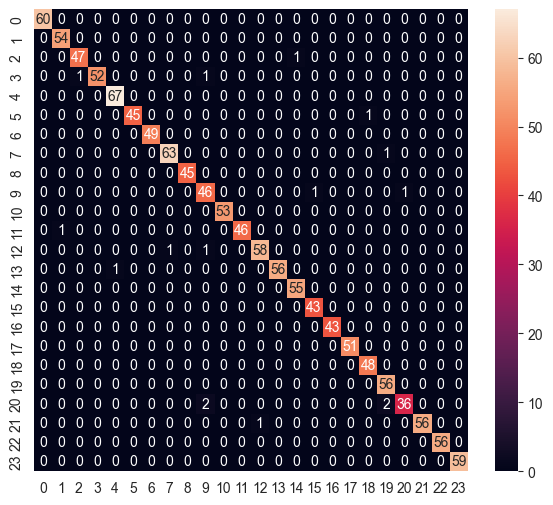

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99        54
           2       0.98      0.98      0.98        48
           3       1.00      0.96      0.98        54
           4       0.99      1.00      0.99        67
           5       1.00      0.98      0.99        46
           6       1.00      1.00      1.00        49
           7       0.98      0.98      0.98        64
           8       1.00      1.00      1.00        45
           9       0.92      0.96      0.94        48
          10       1.00      1.00      1.00        53
          11       1.00      0.98      0.99        47
          12       0.98      0.97      0.97        60
          13       1.00      0.98      0.99        57
          14       0.98      1.00      0.99        55
          15       0.98      1.00      0.99        43
          16       1.00      1.00      1.00        43
     

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

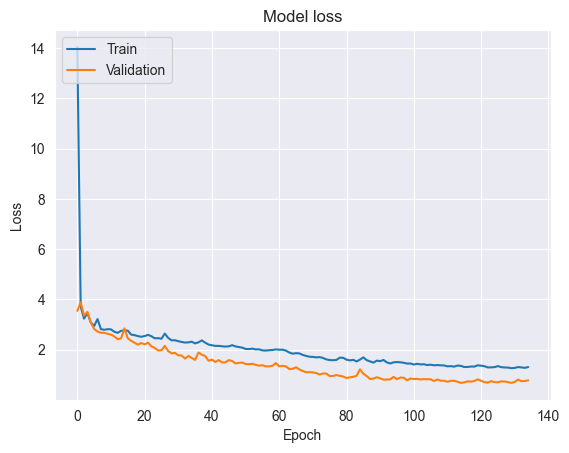

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

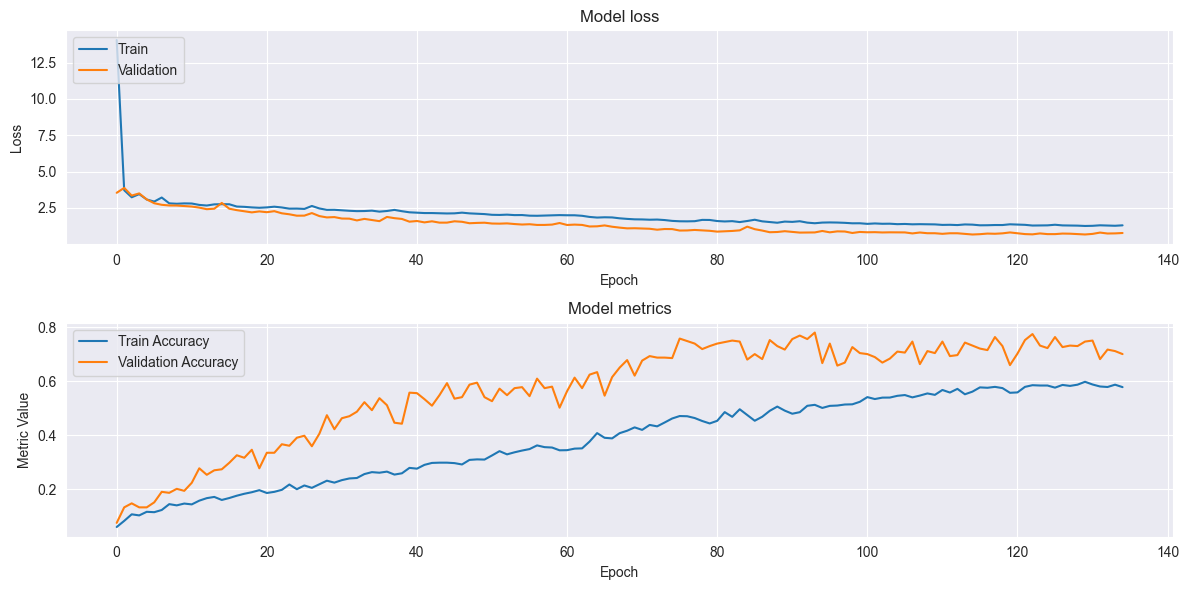

In [14]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()